In [1]:
!which python3

/Users/quert/vicuna-venv/bin/python3


In [4]:
# %cd ~/Documents/Quert/data/NetKu/full_content/
%cd /home/ethan/Documents/Quert/data/edit_NetKu/util

/home/ethan/Documents/Quert/data/edit_NetKu/util


In [3]:
import torch
# import spacy
import difflib
import itertools
import re
import json
import string
import pycountry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# train_pt = torch.load('train.pt')
# test_pt = torch.load('test.pt')
# val_pt = torch.load('val.pt')
train_pt = torch.load('train_labeled.pt')

In [5]:
# check_cands = train_pt[:100]
# torch.save(check_cands, 'check_cands.pt')

In [6]:
# check_cands = torch.load('check_cands.pt')

In [7]:
def get_nlp():
    nlp = None
    spacy_package = 'en_core_web_sm'
    if not nlp:
        try:
            nlp = spacy.load(spacy_package, disable=["tagger" "ner"])
        except:
            import subprocess
            print('downloading spacy...')
            subprocess.run("python3 -m spacy download %s" % spacy_package, shell=True)
            nlp = spacy.load(spacy_package, disable=["tagger" "ner"])
    return nlp

In [8]:
nlp_ner = None
def get_nlp_ner():
    global nlp_ner
    if not nlp_ner:
        nlp_ner = spacy.load(spacy_package, disable=["tagger"])  # just the parser
    return nlp_ner

In [9]:
to_filter = [
    'Share on WhatsApp',
    'Share on Messenger',
    'Reuse this content',
    'Share on LinkedIn',
    'Share on Pinterest' ,
    'Share on Google+',
    'Listen /',
    '– Politics Weekly',
    'Sorry your browser does not support audio',
    'https://flex.acast.com',
    '|',
    'Share on Facebook',
    'Share on Twitter',
    'Share via Email',
    'Sign up to receive',
    'This article is part of a series',
    'Follow Guardian',
    'Twitter, Facebook and Instagram',
    'UK news news',
    'Click here to upload it',
    'Do you have a photo',
    'Listen /',
    'Email View',
    'Read more Guardian',
    'This series is',
    'Readers can recommend ',
    'UK news news',
    'Join the debate',
    'guardian.letters@theguardian.com',
    'More information',
    'Close',
    'All our journalism is independent',
    'is delivered to thousands of inboxes every weekday',
    'with today’s essential stories',
    'Newsflash:',
    'You can read terms of service here',
    'Guardian rating:',
    'By clicking on an affiliate link',
    'morning briefing news',
    'Analysis:',
    'Good morning, and welcome to our rolling coverage',
    'South and Central Asia news',
    'f you have a direct question',
    'sign up to the',
    'You can read terms of service here.',
    'If you want to attract my attention quickly, it is probably better to use Twitter.',
    'UK news',
]
to_filter = list(map(lambda x: x.lower(), to_filter))
starts_with = [
    'Updated ',
    'Here’s the sign-up',
    '[Read more on',
    '[Here’s the list of',
    '[Follow our live coverage',
    '[',
]
contains = [
    'Want to get this briefing by email',
    'Thank youTo'
]
ends_with = [
    ']',
]
last_line_re = re.compile('Currently monitoring (\d|\,)+ news articles')
version_re = re.compile('Version \d+ of \d+')

In [10]:
## general res
clean_escaped_html = re.compile('&lt;.*?&gt;')
end_comma = re.compile(',$')
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
             "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
             "they",
             "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those",
             "am",
             "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did",
             "doing",
             "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
             "with",
             "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to",
             "from",
             "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
             "there",
             "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some",
             "such",
             "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "can", "will", "just", "should",
             "now"]
stopwords_lemmas = list(set(map(lambda x: x.lemma_, get_nlp()(' '.join(stopwords)))))
## lambdas
filter_sents = lambda x: not (
    any(map(lambda y: y in x, contains)) or
    any(map(lambda y: x.startswith(y), starts_with)) or
    any(map(lambda y: x.endswith(y), ends_with))
)

In [11]:
def get_words(s, split_method='spacy'):
    if split_method == 'spacy':
        return list(map(lambda x: x.text, get_nlp()(s)))
    else:
        return s.split()

get_lemmas = lambda s: list(map(lambda x: x.lemma_.lower(), get_nlp()(s)))
filter_stopword_lemmas = lambda word_list: list(filter(lambda x: x not in stopwords_lemmas, word_list))
filter_punct = lambda word_list: list(filter(lambda x: x not in string.punctuation, word_list))


In [12]:
# Convert string into pars -> do filtering than convert back to string format
def filter_lines(a):
    if isinstance(a, list):
        pars = a
    else:
        # pars = a.split('</p>')
        pars = a.split('\n\n')
    output = []
    for p in pars:
        if not any(map(lambda x: x in p.lower(), to_filter)):
            output.append(p)
    if isinstance(a, list):
        return output
    else:
        return '\n\n'.join(output)

In [13]:
def is_dateline(x):
    ## is short enough
    length = len(x.split()) < 6
    # has a country name
    # 1. Does it have an uppercase word?
    has_gpe = any(map(lambda x: x.isupper(), x.split()))
    # 2. Is there a country name?
    if not has_gpe:
        for word in get_words(x):
            try:
                pycountry.countries.search_fuzzy(word)
                has_gpe = True
                break
            except LookupError:
                has_gpe = False
    # 3. Is there a GPE?
    if not has_gpe:
        doc = get_nlp_ner()(x)
        for ent in doc.ents:
            if ent.label_ == 'PERSON':
                has_gpe = True
    ##
    if length and has_gpe:
        return True
    else:
        return False


In [14]:
# Split into sentences
def split_sents(a, perform_filter=True):
    nlp = get_nlp()
    output_sents = []

    # deal with dateline (this can really mess things up...)
    dateline_dashes = ['—', '–']
    for d in dateline_dashes:
        dateline = a.split(d)[0]
        if is_dateline(dateline): ## find the dateline
            ## dateline.
            output_sents.append(dateline.strip())
            ## all other sentences.
            a = d.join(a.split(d)[1:]).strip()
            break

    # get sentences from each paragraph
    # pars = a.split('.\n\n')
    # get pars, then read the sentences from each par
    pars = a.split('.\n\n')
    for p in pars:
        doc = nlp(p)
        sents = list(map(lambda x: x.text, doc.sents))
        output_sents += sents

    
    # filter out garbage/repetitive sentences
    if perform_filter:
        output_sents = filter_lines(output_sents)

    # last-minute processing
    output_sents = list(map(lambda x: x.strip(), output_sents))

    # merge dateline in with the first sentence
    if len(output_sents) > 0:
        if is_dateline(output_sents[0]):
            output_sents = ['—'.join(output_sents[:2])] + output_sents[2:]
    # output_sents = '.\n\n'.join(output_sents)
    return output_sents


In [15]:
# # Running split_sents to docs of each cluster
# splitted_docs = []
# for idx in range(len(test_pt)):
#      splitted_docs.append(split_sents(test_pt[idx]['document'][0]))

In [16]:
# len(splitted_docs)

**Now we have the splitted_docs saves the splitted sentences from each cluster in order**

### Get the diff

In [14]:
# diff = difflib.ndiff('one\ntwo\nthree\n'.splitlines(keepends=True), # one\ntwo\nthree\n
#              'ore\ntno\nemu\n'.splitlines(keepends=True))          # ore\ntno\nemu\n

# print(''.join(diff), end="")
# print('-----')

# diff = list(difflib.ndiff('one\ntwo\nthree\n'.splitlines(keepends=True), # one\ntwo\nthree\n
#              'ore\ntree\nemu\n'.splitlines(keepends=True)))          # ore\ntree\nemu\n

diff = list(difflib.ndiff('I got the pencil.\n\nBut that is not mine.'.splitlines(keepends=True), # one\ntwo\nthree\n
             'I got thes pencil.\n\nBut I think that is belong to Leo.'.splitlines(keepends=True))) # ore\ntree\nemu\n

# print(''.join(diff), end="")

print(list(diff))


['- I got the pencil.\n', '+ I got thes pencil.\n', '?          +\n', '  \n', '- But that is not mine.', '+ But I think that is belong to Leo.']


In [15]:
# from difflib import ndiff
# def modify(src, tgt): # take src in list format, tgt in str format
#     src = '\n\n'.join(src) # idx is under waiting
#     input_docs = src.replace('..\n\n', '.\n\n') # deal with 's, s, \s
#     input_docs = input_docs.replace("'s", "s")
#     input_docs = input_docs.replace("\\", "")
#     input_docs = input_docs.strip()
#     input_summ = tgt.replace('\\\\c', '\n\n')
#     input_summ = input_summ.replace("\\\'s", "'s")
#     input_summ = input_summ.replace("\'s", "s")
#     input_summ = input_summ.replace("\\\'", "")
#     input_summ = input_summ.strip()
#     return input_docs, input_summ

In [16]:
# docs, summs = [], []
# for idx in range(len(val_pt)):
#     doc = val_pt[idx]['document']
#     summ = val_pt[idx]['summary']
#     modified_doc, modified_summ = modify(doc, summ)
#     docs.append(modified_doc)
#     summs.append(modified_summ)
# assert len(docs)==len(summs)
# print(len(docs))

In [17]:
# # Output the processed .pt
# wrap = []
# # src_strs = output_str.copy()

# for idx in range(len(docs)):
#     idx_content = {}
#     idx_content['document'] = docs[idx]
#     idx_content['summary'] = summs[idx]
#     wrap.append(idx_content)
# torch.save(wrap, 'processed_val.pt')
# pro_pt = torch.load('processed_val.pt')
# print(len(pro_pt))

In [17]:
def get_word_diff_ratio(s_old, s_new):
    s_old_words, s_new_words = get_words(s_old), get_words(s_new)
    return difflib.SequenceMatcher(None, s_old_words, s_new_words).ratio()

In [18]:
# def get_list_diff(l_old, l_new):
#     vars_old = []
#     vars_new = []
#     diffs = list(difflib.ndiff(l_old, l_new))
#     in_question = False
#     for idx, item in enumerate(diffs):
#         label, text = item[0], item[2:]
#         if label == '?':
#             continue
#         # Add the function to compute matching ratio here: similar as below
#         if label == '-':
#             vars_old.append({
#                 'text': text,
#                 'tag': '-'
#             })
#             if (
#                     ## if something is removed from the old sentnece, a '?' will be present in the next idx
#                     ((idx < len(diffs) - 1) and (diffs[idx + 1][0] == '?'))
#                     ## if NOTHING is removed from the old sentence, a '?' might still be present in 2 idxs, unless the next sentence is a - as well.
#                  or ((idx < len(diffs) - 2) and (diffs[idx + 2][0] == '?') and diffs[idx + 1][0] != '-')
#             ):
#                 in_question = True
#                 continue

#             ## test if the sentences are substantially similar, but for some reason ndiff marked them as different.
#             if (idx < len(diffs) - 1) and (diffs[idx + 1][0] == '+'):
#                 _, text_new = diffs[idx + 1][0], diffs[idx + 1][2:]
#                 if get_word_diff_ratio(text, text_new) > .9:
#                     in_question = True
#                     vars_new.append({
#                         'text': '',
#                         'tag': ' '
#                     })
#         # output_ratio = []
#         if label == '+': # and the matching ratio<.5, tag with "*"
#             # if label=='+' and the matching ratio is between .5 and .9, tag with '*'.
#             # aka [SUB]
#             text_old, text_new = diffs[idx-1][2:], diffs[idx][2:] # possible problems here 
#             ratio = get_word_diff_ratio(text_old, text_new)
#             if ratio >= .8:
#                 vars_old.append({
#                     'text':'',
#                     'tag': ' '
#                     })
#                 vars_new.append({
#                     'text': text_new,
#                     'tag': ' ' # keep
#                     })
#             elif ratio <= .3:
#                 vars_old.append({
#                     'text':'',
#                     'tag': ' '
#                     })
#                 vars_new.append({
#                     'text': text_new,
#                     'tag': '+' # add
#                     })
#             else:
#                 vars_old.append({
#                     'text':'',
#                     'tag': ' '
#                     })
#                 vars_new.append({
#                     'text': text_new,
#                     'tag': '*' # sub
#                     })
#     return vars_old, vars_new 

In [19]:
def get_list_diff(l_old, l_new):
    vars_old = []
    vars_new = []
    diffs = list(difflib.ndiff(l_old, l_new))
    in_question = False
    for idx, item in enumerate(diffs):
        label, text = item[0], item[2:]
        if label == '?':
            continue

        elif label == '-':
            vars_old.append({
                'text': text,
                'tag': '-'
            })
            if (
                    ## if something is removed from the old sentnece, a '?' will be present in the next idx
                    ((idx < len(diffs) - 1) and (diffs[idx + 1][0] == '?'))
                    ## if NOTHING is removed from the old sentence, a '?' might still be present in 2 idxs, unless the next sentence is a - as well.
                 or ((idx < len(diffs) - 2) and (diffs[idx + 2][0] == '?') and diffs[idx + 1][0] != '-')
            ):
                in_question = True
                continue

            ## test if the sentences are substantially similar, but for some reason ndiff marked them as different.
            if (idx < len(diffs) - 1) and (diffs[idx + 1][0] == '+'):
                _, text_new = diffs[idx + 1][0], diffs[idx + 1][2:]
                if get_word_diff_ratio(text, text_new) > .9:
                    in_question = True
                    continue

            vars_new.append({
                'text': '',
                'tag': ''
            })


        elif label == '+':
            old_text, new_text = diffs[idx-2][2:], diffs[idx][2:]
            sents_ratio = get_word_diff_ratio(old_text, new_text) 
            
            if sents_ratio >= .8:
                vars_new.append({
                    'text': new_text,
                    'tag': ' '
                })
            elif sents_ratio < .3:
                vars_new.append({
                    'text': new_text,
                    'tag': '+'
                })
            else:
                vars_new.append({
                    'text': new_text,
                    'tag': '*'
                })
            # if in_question:
            #     in_question = False
            # else:
            #     vars_old.append({
            #         'text':'',
            #         'tag': ' '
            #     })
        else:
            vars_old.append({
                'text': text,
                'tag': ' '
            })
            vars_new.append({
                'text': text,
                'tag': ' '
            })

    return vars_old, vars_new

In [20]:
# import difflib
# old_text = ['See the above main articles for much more info, and for casualty numbers for coalition nations, contractors, non-Iraqi civilians, journalists, media helpers, aid workers, wounded, etc.. Casualty figures, especially Iraqi ones, are highly disputed.']
# # new_text = ['By the end of the spring uprising, the cities of Fallujah, Samarra, Baquba, and Ramadi had been left under guerrilla control with coalition patrols in the cities at a minimum.']

# new_text = ['See the above main articles for much more info, and for casualty numbers for coalition nations, contractors, non-Iraqi civilians, journalists, media helpers, aid workers, wounded, etc.']
# # lst = list(difflib.ndiff(old_text, new_text))
# # lst
# get_word_diff_ratio(old_text[0], new_text[0])
# # len(lst)

In [21]:
def cluster_edits(vo, vn):
    clustered_edits = []
    current_cluster = []
    for o, n in list(zip(vo, vn)):
        if (o['tag'] in ['+', '-']) or (n['tag'] in ['+', '-']):
            current_cluster.append((o, n))
        ##
        if o['tag'] == ' ' and n['tag'] == ' ':
            if len(current_cluster) > 0:
                clustered_edits.append(current_cluster)
                current_cluster = []
            clustered_edits.append([(o, n)])
    if len(current_cluster) > 0:
        clustered_edits.append(current_cluster)
    return clustered_edits

In [22]:
def merge_sents(idx_i, idx_j, a, c):
    """Merges two sentences without spacing errors."""
    si_text = c[idx_i][a]['text']
    sj_text = c[idx_j][a]['text']

    if isinstance(si_text, (list, tuple)):
        output_list = list(si_text)
    else:
        output_list = [(idx_i, si_text)]
    if isinstance(sj_text, (list, tuple)):
        output_list += sj_text
    else:
        output_list.append((idx_j, sj_text))
    return output_list

In [23]:
def merge_sents_list(t):
    t = sorted(t, key=lambda x: x[0])
    t = list(map(lambda x: x[1].strip(), t))
    t = ' '.join(t)
    return ' '.join(t.split())

In [24]:
def text_in_interval(c, idx_i, idx_j, version):
    idx_small, idx_large = min([idx_i, idx_j]), max([idx_i, idx_j])
    return any(map(lambda idx: c[idx][version]['text'].strip() != '',  range(idx_small+1, idx_large)))

In [25]:
def lemmatize_sentence(s, cache):
    if isinstance(s, str) and s in cache:
        return cache[s], cache
    if isinstance(s, list):
        s = merge_sents_list(s)
    s_lemmas = get_lemmas(s)
    s_lemmas = filter_stopword_lemmas(s_lemmas)
    s_lemmas = filter_punct(s_lemmas)
    cache[s] = s_lemmas
    return cache[s], cache

In [26]:
def check_subset(s1_lemmas, s2_lemmas, slack=.5):
    """Checks if the second sentence is nearly a subset of the first, with up to `slack` words different."""
    ### get all text (might be a list).
    if len(s2_lemmas) > len(s1_lemmas):
        return False
    if len(s2_lemmas) > 50:
        return False
    ### check match.
    matches = sum(map(lambda word: word in s1_lemmas, s2_lemmas))
    return matches >= (len(s2_lemmas) * (1 - slack))

In [27]:
def swap_text_spots(c, old_spot_idx, new_spot_idx, version):
    ## swap text
    text_old = c[old_spot_idx][version]['text']
    text_new = c[new_spot_idx][version]['text']
    c[new_spot_idx][version]['text'] = text_old
    c[old_spot_idx][version]['text'] = text_new
    ## swap tags
    tag_new = c[new_spot_idx][version]['tag']
    tag_old = c[old_spot_idx][version]['tag']
    c[new_spot_idx][version]['tag'] = tag_old
    c[old_spot_idx][version]['tag'] = tag_new
    return c

In [28]:
import copy
def merge_cluster(c, slack=.5):
    c = list(filter(lambda x: x[0]['text'] != '' or x[1]['text'] != '', c))
    old_c = copy.deepcopy(c)
    r_c = range(len(c))
    keep_going = True
    loop_idx = 0
    cache = {}

    while keep_going:
        for active_version in [0, 1]:
            inactive_version = abs(active_version - 1)
            for idx_i, idx_j in itertools.product(r_c, r_c):
                # [(0, 0), (0, 1), (1, 0), (1, 1)]
                idx_i, idx_j = (idx_i, idx_j) if active_version == 0 else (idx_j, idx_i)
                if (
                        (idx_i != idx_j)
                        and (c[idx_j][active_version]['text'] != '')
                        # and (c[idx_j][inactive_version]['text'] == '')
                        and (c[idx_i][inactive_version]['text'] != '')
                ):

                    # print('active: %s, idx_i: %s, idx_j: %s' % (active_version, idx_i, idx_j))
                    s1_lemmas, cache = lemmatize_sentence(c[idx_i][inactive_version]['text'], cache)
                    s2_lemmas, cache = lemmatize_sentence(c[idx_j][active_version]['text'], cache)
                    if check_subset(s1_lemmas, s2_lemmas, slack=slack):
                        # if there's a match, first check:
                        combined_text_active = merge_sents(idx_i, idx_j, active_version, c)
                        combined_text_inactive = merge_sents(idx_i, idx_j, inactive_version, c)
                        c[idx_j][active_version]['text'] = combined_text_active
                        c[idx_i][active_version]['text'] = ''
                        c[idx_i][inactive_version]['text'] = combined_text_inactive
                        c[idx_j][inactive_version]['text'] = ''
                        # print('FOUND')
                        # print(c)
                        # print('active: %s, idx_i: %s, idx_j: %s' % (active_version, idx_i, idx_j))

                        #    1. if the two idx's are adjacent, then move the active.
                        if abs(idx_i - idx_j) == 1:
                            # print('1.')
                            c = swap_text_spots(c, new_spot_idx=idx_i, old_spot_idx=idx_j, version=active_version)

                        #    2. if there's both >=1 active AND >=1 inactive in between, don't do anything.
                        elif text_in_interval(c, idx_i, idx_j, active_version) and text_in_interval(c, idx_i, idx_j, inactive_version):
                            # print('2.')
                            pass

                        #    3. if there's text in the active version between the two idx's, move the inactive.
                        elif text_in_interval(c, idx_i, idx_j, active_version):
                            # print('3.')
                            c = swap_text_spots(c, new_spot_idx=idx_j, old_spot_idx=idx_i, version=inactive_version)

                        #    4. if there's text in the inactive in between the two idx's, move the active.
                        elif text_in_interval(c, idx_i, idx_j, inactive_version):
                            # print('4.')
                            c = swap_text_spots(c, new_spot_idx=idx_i, old_spot_idx=idx_j, version=active_version)

                        #   5. if there's no text inbetween the idx's in either the active or the inactive, move the active.
                        elif not (
                                text_in_interval(c, idx_i, idx_j, active_version) and
                                text_in_interval(c, idx_i, idx_j, inactive_version)
                        ):
                            # print('5.')
                            c = swap_text_spots(c, new_spot_idx=idx_i, old_spot_idx=idx_j, version=active_version)

                        ## merge list/text
                        for idx, version in itertools.product([idx_i, idx_j], [active_version, inactive_version]):
                            if isinstance(c[idx][version]['text'], list):
                                c[idx][version]['text'] = merge_sents_list(c[idx][version]['text'])

        ## one more merge for safety
        for idx, version in itertools.product(r_c, [active_version, inactive_version]):
            if isinstance(c[idx][version]['text'], list):
                c[idx][version]['text'] = merge_sents_list(c[idx][version]['text'])

        if (c == old_c) or (loop_idx > 10000):
            # print('done, idx: %s' % loop_idx)
            keep_going = False
            loop_idx = 0
        else:
            loop_idx += 1
            # print('one more')
            old_c = copy.deepcopy(c)

    return c

In [29]:
def merge_all_clusters(vo, vn, slack=.5):
    clustered_edits = cluster_edits(vo, vn)
    output_edits = []
    for c in clustered_edits:
        if len(c) == 1:
            c_i = c[0]
            if not (c_i[0]['text'] == '' and c_i[1]['text'] == ''):
                output_edits.append(c_i)
        else:
            c_new = merge_cluster(c, slack=slack)
            for c_i in c_new:
                if not (c_i[0]['text'] == '' and c_i[1]['text'] == ''):
                    output_edits.append(c_i)

    if len(output_edits) == 0:
        return None, None

    return zip(*output_edits)

In [30]:
def get_sentence_diff(a_old, a_new, filter_common_sents=True, merge_clusters=True, slack=.5):
    ## split sentences
    a_old_sents = split_sents(a_old)
    a_new_sents = split_sents(a_new)
    if filter_common_sents:
        a_old_sents = list(filter(filter_sents, a_old_sents))
        a_new_sents = list(filter(filter_sents, a_new_sents))
    ## group list
    vers_old, vers_new = get_list_diff(a_old_sents, a_new_sents)
    ## fix errors/ align sentences
    if merge_clusters:
        vers_old, vers_new = merge_all_clusters(vers_old, vers_new, slack=slack)
    return vers_old, vers_new 

In [50]:
def addMark(src):
    input_docs = src.replace('\n\n', '\n\n#####**')
    input_docs = input_docs.replace('[citation needed]', '')
    return input_docs

def fixMark(src):
    # input_docs = src.replace('\n\n', '.\n\n')
    input_docs = src.replace('#####', '.\n\n')
    return input_docs


In [51]:
# Run (main)
old_ver = addMark(train_pt[1]['document'])
new_ver = addMark(train_pt[1]['summary'])
# old, new = get_sentence_diff(fixMark(old_ver), fixMark(new_ver))
old, new = get_sentence_diff(old_ver, new_ver)
# print('Old Version')
# print(old_ver)
# print('\nNew Version')
# print(new_ver)
# print('-----------------')
# print('\nAfter Parsing')
# print(old)
# print('--')
print(new)

({'text': 'The Iraq War (2003 to the present), also known as the Second Gulf War is an ongoing war started by the 2003 invasion of Iraq.', 'tag': ' '}, {'text': 'Following the successful overthrow of the then Iraq President Saddam Hussein, the subsequent occupation of Iraq by a United States-led coalition has resulted in ongoing asymmetric warfare between an insurgency and the occupying coalition forces and sectarian violence between Sunni and Shia Iraqis.', 'tag': ' '}, {'text': 'The causes and consequences of the war remain controversial.', 'tag': '+'}, {'text': '#####**Prior to invasion, the United States and other coalition forces involved in the 1991 Persian Gulf War had been engaged in a low-level conflict with Iraq, by enforcing the two Iraqi no-fly zones in the north and the south of the country.', 'tag': ' '}, {'text': 'Iraqi air-defense installations repeatedly targeted American and British air patrols and were often engaged by the coalition aircraft shortly afterwards.', 'ta

In [47]:
new_ver

'The Iraq War (2003 to the present), also known as the Second Gulf War is an ongoing war started by the 2003 invasion of Iraq. Following the successful overthrow of the then Iraq President Saddam Hussein, the subsequent occupation of Iraq by a United States-led coalition has resulted in ongoing asymmetric warfare between an insurgency and the occupying coalition forces and sectarian violence between Sunni and Shia Iraqis.   The causes and consequences of the war remain controversial.  \n\n#####Prior to invasion, the United States and other coalition forces involved in the 1991 Persian Gulf War had been engaged in a low-level conflict with Iraq, by enforcing the two Iraqi no-fly zones in the north and the south of the country. Iraqi air-defense installations repeatedly targeted American and British air patrols and were often engaged by the coalition aircraft shortly afterwards. Approximately nine months after the 9/11 attacks, the U.S. initiated Operation Southern Focus as a change to i

In [49]:
# new_ver
print(new)

({'text': 'The Iraq War (2003 to the present), also known as the Second Gulf War is an ongoing war started by the 2003 invasion of Iraq.', 'tag': ' '}, {'text': 'Following the successful overthrow of the then Iraq President Saddam Hussein, the subsequent occupation of Iraq by a United States-led coalition has resulted in ongoing asymmetric warfare between an insurgency and the occupying coalition forces and sectarian violence between Sunni and Shia Iraqis.', 'tag': ' '}, {'text': 'The causes and consequences of the war remain controversial.', 'tag': '+'}, {'text': '#####Prior to invasion, the United States and other coalition forces involved in the 1991 Persian Gulf War had been engaged in a low-level conflict with Iraq, by enforcing the two Iraqi no-fly zones in the north and the south of the country.', 'tag': ' '}, {'text': 'Iraqi air-defense installations repeatedly targeted American and British air patrols and were often engaged by the coalition aircraft shortly afterwards.', 'tag'

In [ ]:
keep, add, sub = [], [], []
for idx in range(len(train_pt)):
# for idx in range(0): 
    old_ver = addMark(train_pt[idx]['document'])
    new_ver = addMark(train_pt[idx]['summary'])
    old, new = get_sentence_diff(fixMark(old_ver), fixMark(new_ver))
    ke, ad, su = 0, 0, 0
    for i in range(len(new)):
        if new[i]['tag']==' ': ke+=1
        elif new[i]['tag']=='+': ad+=1
        else: su+=1
    keep.append(ke)
    add.append(ad)
    sub.append(su)

In [35]:
### Testing 

In [ ]:
old_ver = addMark(train_pt[1]['document'])
new_ver = addMark(train_pt[1]['summary'])
old, new = get_sentence_diff(fixMark(old_ver), fixMark(new_ver))
output = Labeling(new)
output

In [ ]:
# For all clusters
keep_all, add_all, sub_all = [], [], []
for idx in range(5):
    old_ver = addMark(train_pt[idx]['document'])
    new_ver = addMark(train_pt[idx]['summary'])
    old, new = get_sentence_diff(fixMark(old_ver), fixMark(new_ver))
    add, sub, keep = 0, 0, 0
    for idd in range(len(new)):
        if new[idd]['tag']==' ' and new[idd]['text']!='':
            keep+=1
        elif new[idd]['tag']=='+' and new[idd]['text']!='': 
            add+=1
        elif new[idd]['tag']=='#' and new[idd]['text']!='':
            sub+=1
    keep_all.append(keep)
    add_all.append(add)
    sub_all.append(sub)

In [13]:
%cd ~/Documents/Quert/data/edit_NetKu/util

/home/ethan/Documents/Quert/data/edit_NetKu/util


In [45]:
log_add = pd.read_csv('log_add.csv')
log_keep = pd.read_csv('log_keep.csv')
log_sub = pd.read_csv('log_sub.csv')
add_arr = log_add.iloc[:, 0].to_numpy()
keep_arr = log_keep.iloc[:, 0].to_numpy()
sub_arr = log_sub.iloc[:, 0].to_numpy()

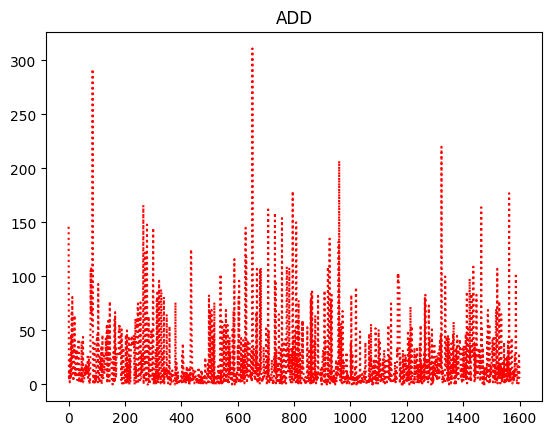

In [42]:
x = [i for i in range(1601)]

plt.title("ADD")
plt.plot(x, add_arr, color="red", linestyle='dotted')

plt.show()

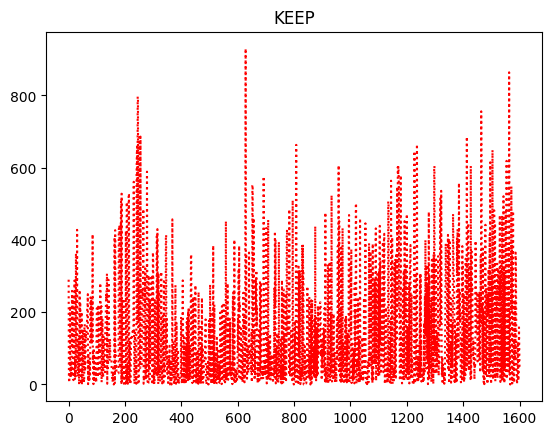

In [46]:
x = [i for i in range(1601)]

plt.title("KEEP")
plt.plot(x, keep_arr, color="red", linestyle='dotted')

plt.show()

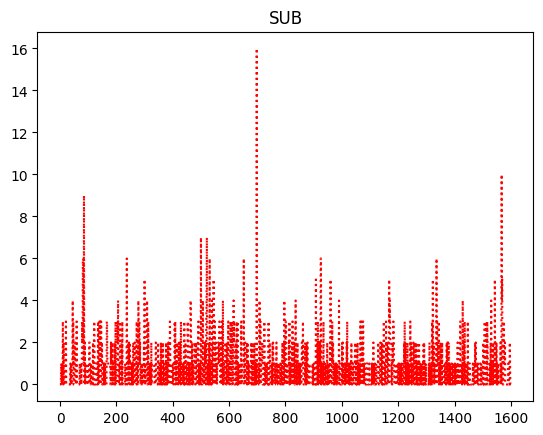

In [47]:
x = [i for i in range(1601)]

plt.title("SUB")
plt.plot(x, sub_arr, color="red", linestyle='dotted')

plt.show()

In [35]:
def Labeling(new):
    labeled_data = []
    for idx in range(len(new)):
        if new[idx]['tag']==' ' and new[idx]['text']!='':
            labeled_data.append(' [KEEP] ' + new[idx]['text'] + ' [/KEEP]')
        # elif new[idx]['tag']=='-' and new[idx]['text']!='':
        #     labeled_data.append(' [RM] '+new[idx]['text']+' [/RM]')
        elif new[idx]['tag']=='+' and new[idx]['text']!='': 
            labeled_data.append(' [ADD] '+new[idx]['text']+' [/ADD]')
        # elif new[idx]['tag']=='*' and new[idx]['text']!='':
        else:
            labeled_data.append(' [SUB] '+new[idx]['text']+' [/SUB]')
    return ''.join(labeled_data)

In [36]:
labeled = Labeling(new)
labeled

' [KEEP] Hugo Rafael Chávez Frías (IPA: ) (born July 28, 1954) is the 53rd and current President of Venezuela. [/KEEP] [ADD] As the leader of the "Bolivarian Revolution," Chávez promotes his vision of democratic socialism, Latin American integration, and anti-imperialism. [/ADD] [KEEP] He is also an ardent critic of neoliberal globalization and  US foreign policy [/KEEP] [KEEP] A career military officer, Chávez founded the leftist Fifth Republic Movement after orchestrating a failed 1992 coup détat against former president Carlos Andrés Pérez. [/KEEP] [KEEP] Chávez was elected President in 1998 on promises of aiding Venezuelas poor majority, and was reelected in 2000. [/KEEP] [KEEP] Domestically, Chávez has launched massive Bolivarian Missions, whose goals are to combat disease, illiteracy, malnutrition, poverty, and other social ills. [/KEEP] [KEEP] Abroad, Chávez has acted against the Washington Consensus by supporting alternative models of economic development, and has adv

In [ ]:
def get_changes(old_doc, new_doc):
    new_document = []
    old_document = []
    new_sentences = []
    removed_sentences = []

    same_sentences = []
    changed_sentence_pairs = []

    for s_idx, (s_old, s_new) in enumerate(zip(old_doc, new_doc)):
        ###
        if s_old['text'].strip() != '':
            old_document.append(s_old['text'])
        if s_new['text'].strip() != '':
            new_document.append(s_new['text'])

        ###
        if s_old['tag'] == '-' and s_new['tag'] == '+':
            changed_sentence_pairs.append((s_idx, (s_old['text'], s_new['text'])))

        ###
        if s_old['tag'] == ' ' and s_new['tag'] == '+':
            new_sentences.append(s_new['text'])

        ###
        if s_new['tag'] == ' ' and s_old['tag'] == '-':
            removed_sentences.append(s_old['text'])

        if s_new['tag'] == ' ' and s_old['tag'] == ' ':
            same_sentences.append(s_old['text'])

    return {
        'docs': {'old_doc': old_document,
                 'new_doc': new_document,
                 },
        'sentences': {'added_sents': new_sentences,
                      'removed_sents': removed_sentences,
                      'changed_sent_pairs': changed_sentence_pairs
                      }
    }

In [ ]:
from difflib import ndiff
old_txt = 'I like it. But its not happened'
new_txt = 'I dont like it. Its happened!'

l_old, l_new = old_txt.split('. '), new_txt.split('. ')
# get_word_diff_ratio(old_txt, new_txt)
diffs = list(difflib.ndiff(l_old, l_new))
diffs

In [ ]:
def pars_and_calculatetokens(instance):
    pars = instance.split('\n\n')
    rec_all = []
    for par in pars:
        num_add, num_sub = 0, 0
        par_rec = []
        for token in par.split():
            if token==['ADD']: num_add+=1
            elif token==['SUB']: num_sub+=1
            num_edits = num_add + num_sub
            par_rec.append(num_edits)
        rec_all.append(num_edits)
    return rec_all 

In [ ]:
for idx in range(len(train_pt)):
    instance = train_pt[idx]['content']
    rec = pars_and_calculatetokens(instance)

In [46]:
import re
text = '[KEEP] I dont like him [/KEEP] [ADD] But its is my destiny [\ADD]'
# splitted = re.split('str([[\d+]])', text)
# splitted = re.split('\[\ADD]', text)
converted = re.sub(r'\[.....]*', '. ', text)
converted = converted.replace('  .', '')
converted = converted.replace(' .', '.')
# \[\Adim]''
converted

'.  I dont like him. But its is my destiny. '

In [51]:
text = '[KEEP] I dont like him [/KEEP] [ADD] But its is my destiny [\ADD]'
keep = 0
add = 0
for token in text.split():
    if token=='[KEEP]': keep+=1
    elif token=='[ADD]': add+=1
print(keep)
print(add)


1
1


In [15]:
re_labeled = torch.load('train_relabeled.pt')

In [18]:
len(re_labeled)

1602

### PRIMERA

In [1]:
%cd /home/ethan/Documents/Quert/PRIMER

/home/ethan/Documents/Quert/PRIMER


In [3]:
from transformers import AutoTokenizer
from longformer import LongformerEncoderDecoderForConditionalGeneration
from longformer import LongformerEncoderDecoderConfig

tokenizer = AutoTokenizer.from_pretrained('./PRIMER_model/')
config = LongformerEncoderDecoderConfig.from_pretrained('./PRIMER_model/')
model = LongformerEncoderDecoderForConditionalGeneration.from_pretrained(
            './PRIMER_model/', config=config)

In [5]:
import torch
torch.cuda.is_available()

True